In [1]:
import numpy as np
import cma

## Define deviated environments

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart}-{masspole}-{length}-{force_mag}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state):
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

### Visualize gym helpers

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import time
%matplotlib inline


# Define visual experiment
def init_fig(env):
    plt.figure()
    plt.title(f"{env.spec.id} | Episode: 0 | Step: 0 | Reward: 0.0")
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, episode, step, total_reward, done):
    plt.title(f"{env.spec.id} | Episode: {episode} | Step: {step} | Reward: {total_reward} | Done: {done}")
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

def visual_experiment(env, next_action, max_episode_steps=100, max_episodes=3, visualize_in_notebook=True, sleep=0.01):
    episode_rewards = []
    env.reset()

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)

    for episode in range(1, max_episodes+1):
        # reset env
        time.sleep(1)
        obs = env.reset()
        total_reward = 0.0
        
        for step in range(1, max_episode_steps+1):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            
            if visualize_in_notebook:
                update_fig(img, env, episode, step, total_reward, done)
            else:
                env.render()
            
            if sleep > 0.0:
                time.sleep(sleep)

        episode_rewards.append(total_reward)

    print(f"Rewards: {episode_rewards}")
    print(f"Mean reward of {len(episode_rewards)} episodes: {np.mean(episode_rewards)}")
    print(f"Std reward of {len(episode_rewards)} episodes: {np.std(episode_rewards)}")

## Define variables and objective function

In [4]:
def scale_x(x, bounds):
    """Scale the input numbers in [0, 1] to the range of each variable"""
    return bounds[:, 0] + x * (bounds[:, 1] - bounds[:, 0])

def normalize_x(x_scaled, bounds):
    return (x_scaled - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

In [5]:
# define variables and their bounds
masscart = [0.001, 2.0]
force_mag = [0.001, 20.0]
env_bounds = np.array([
    masscart,
    force_mag
])

# define objective function
x_original = [
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
]

# l-2 norm distance, the input x is in the original domain
def deviation_dist(x):
    """The variables of the objective function are normalized to [0, 1)"""
    return np.sqrt(np.sum((x - x_original) ** 2))

# wrapped objective function where input x is in [0, 1] and should be scaled to the original domain
def scaled_deviation_dist(x):
    return deviation_dist(scale_x(x, env_bounds))

## Define RL Agent

In [6]:
# load agent
from stable_baselines3 import PPO

# TODO: PPO seems to be non-deterministic
model_ppo = PPO.load("best_model")

In [7]:
from stable_baselines3 import DQN

model_dqn = DQN.load("best_dqn")

#### IMPORTANT: the agent is often non-deterministic

In [8]:
env = MutatedCartPoleEnv()
env.seed(19279)

r1 = []
a1 = []

obs = env.reset()
for _ in range(50):
    r1.append(obs)
    action = model_dqn.predict(obs, deterministic=True)[0] # deterministic=True !!!
    a1.append(action)
    obs, reward, done, info = env.step(action)
env.close()

env = MutatedCartPoleEnv()
env.seed(19279)

r2 = []
a2 = []

obs = env.reset()
for _ in range(50):
    r2.append(obs)
    action = model_dqn.predict(obs, deterministic=True)[0]
    a2.append(action)
    obs, reward, done, info = env.step(action)
env.close()

In [9]:
# the row that the observation becomes different
np.where(np.array(r1) != np.array(r2))

(array([], dtype=int64), array([], dtype=int64))

In [10]:
# the row that the action becomes different
np.where(np.array(a1) != np.array(a2))

(array([], dtype=int64),)

## Define STL robustness estimation functions

In [11]:
model = model_dqn
max_episode_steps = 200
max_episodes = 100
seed = 19279

In [12]:
# Compute robustness value of the STL formula:
#   G ( pos > -2.4 & pos < 2.4 & angle > -12 degree & angle < 12 degree )
import signal_tl as stl

pos = stl.Predicate('pos')
angle = stl.Predicate('angle')

pos_threshold = 2.4
angle_threshold = 12 * 2 * np.pi / 360

phi = stl.Always(
    (pos > -pos_threshold) & (pos < pos_threshold) &\
    (angle > -angle_threshold) & (angle < angle_threshold)
)

def compute_STL_robustness(records):
    if records.ndim == 2:
        records = np.array([records])
    
    time_index = np.arange(records.shape[1])
    robs = []
    for i in range(len(records)):
        trace = {
            "pos": stl.Signal(records[i, :, 0], time_index),
            "angle": stl.Signal(records[i, :, 2], time_index)
        }
        rob = stl.compute_robustness(phi, trace)
        robs.append(rob.at(0))
    return np.array(robs)

### Estimate robustness by random sampling

In [13]:
def random_sample(env, next_action, max_episode_steps=100, max_episodes=3):
    space = env.observation_space
    # episode_rewards = []
    episode_obs_records = []

    for episode in range(max_episodes):
        # reset env
        obs = env.reset()
        # total_reward = 0.0
        obs_records = [obs]
        out_space = False
        
        for step in range(max_episode_steps):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            
            # total_reward += reward
            
            # if the observation is out of the space, clip it and then terminate the episode
            if np.sum(obs < space.low) > 0 or np.sum(obs > space.high) > 0:
                obs = np.clip(obs, space.low, space.high)
                out_space = True
            obs_records.append(obs)
            
            if out_space:
                obs_records = np.append(obs_records, np.full((max_episode_steps-step-1, len(obs)), obs), axis=0)
                break

        # episode_rewards.append(total_reward)
        episode_obs_records.append(obs_records)

    # return np.array(episode_rewards), np.array(episode_obs_records)
    return np.array(episode_obs_records)

In [14]:
# define constraints where input x is in the original domain
def estimate_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)

    # fix the seed so that we can fix the initial states for sampling
    records = random_sample(
        env,
        lambda obs: model.predict(obs, deterministic=True)[0],
        max_episode_steps=max_episode_steps,
        max_episodes=max_episodes
    )

    env.close()

    robs = compute_STL_robustness(records)
    return robs.min()

# wrapped constraints function where input x is in [0, 1] and should be scaled to the original domain
def scaled_estimate_min_STL_robustness(x):
    return estimate_min_STL_robustness(scale_x(x, env_bounds))

In [15]:
def visualize_deviated_env(x, model):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    visual_experiment(env, lambda obs: model.predict(obs, deterministic=True)[0], max_episode_steps=200, max_episodes=1)
    env.close()

### Estimate min robustness by using CMA-ES by varying the initial state

In [39]:
# define the range of the initial set
init_range = np.repeat([[-0.05, 0.05]], 4, axis=0); init_range

array([[-0.05,  0.05],
       [-0.05,  0.05],
       [-0.05,  0.05],
       [-0.05,  0.05]])

In [40]:
def episode_by_init(env, x, next_action, max_episode_steps):
    space = env.observation_space
    obs = env.reset_to(x)
    obs_records = [obs]
    out_space = False
    
    for step in range(max_episode_steps):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)

        # if the observation is out of the space, clip it and then terminate the episode
        if np.sum(obs < space.low) > 0 or np.sum(obs > space.high) > 0:
            obs = np.clip(obs, space.low, space.high)
            out_space = True
        obs_records.append(obs)

        if out_space:
            obs_records = np.append(obs_records, np.full((max_episode_steps-step-1, len(obs)), obs), axis=0)
            break
    
    return np.array(obs_records)


def cma_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    def objective(y):
        record = episode_by_init(env, y, lambda obs: model.predict(obs, deterministic=True)[0],
                                 max_episode_steps=max_episode_steps)
        return compute_STL_robustness(record)[0]
    
    y0 = np.zeros(4)
    sigma0 = 0.2
    min_x, es = cma.fmin2(
        lambda y: objective(scale_x(y, init_range)),
        y0,
        sigma0,
        {'bounds': [0.0, 1.0], 'maxfeval': max_episodes, 'ftarget': 0.0, 'verbose': -9, 'seed': seed}
    )
    
    env.close()
    
    return es.result.fbest

def scaled_cma_min_STL_robustness(x):
    return cma_min_STL_robustness(scale_x(x, env_bounds))

### Compare two sampling methods

In [44]:
# CMA is better when the agent is deterministic
for x in np.random.rand(5, 2):
    est1 = scaled_estimate_min_STL_robustness(x)
    est2 = scaled_cma_min_STL_robustness(x)
    if est1 < est2:
        print(est1, est2, "Random Sample")
    else:
        print(est1, est2, "CMA")

0.11117959929819557 0.07901222421045753 CMA


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


-2.4000001907348634 -2.4000001907348634 CMA
-0.20943952189569023 -0.20943952189569023 CMA
0.11867288662310096 0.0773280353676841 CMA
0.11424747271652672 0.06523838056440803 CMA


### CMA-ES for minimizing the deviation s.t. the STL is violated (robustness value <= 0)

In [45]:
# set initial variable values to the default value
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

cfun = cma.ConstrainedFitnessAL(scaled_deviation_dist, lambda x: [scaled_cma_min_STL_robustness(x)], find_feasible_first=True)
x, es = cma.fmin2(
    cfun,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolfun': 1e-3, 'tolx': 1e-5, 'timeout': 30 * 60},
    callback=cfun.update
)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=219234, Wed Jul  6 17:41:04 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 6.489501916561678e-03 1.0e+00 2.25e-01  2e-01  2e-01 0:23.5
    2     12 8.095514946161260e-01 1.5e+00 2.30e-01  2e-01  2e-01 0:51.2
    3     18 -4.854824703790608e+00 1.2e+00 2.75e-01  3e-01  3e-01 1:14.4
    4     24 1.623895157891531e+00 1.2e+00 2.47e-01  2e-01  2e-01 1:33.1
    5     30 -9.599217612331771e+00 1.2e+00 2.70e-01  2e-01  3e-01 1:51.6
    6     36 -6.705606507904074e+00 1.8e+00 2.56e-01  2e-01  3e-01 2:10.3
    7     42 2.569608594657548e+00 1.7e+00 2.14e-01  1e-01  2e-01 2:29.1
    8     48 -1.339671474304489e+01 1.7e+00 2.04e-01  1e-01  2e-01 2:43.4
    9     54 -4.126437156900328e+00 1.6e+00 2.05e-01  1e-01  2e-01 2:57.5
   10     60 3.248967666375831e+00 1.7e+00 2.18e-01  2e-01  2e-01 3:11.5
   11     66 -7.979446854227294e-01 1.4e+00 2.13e-01  1e-01  2e-01 3:30.0
   12     72 5.92546937519269

In [46]:
es.result

CMAEvolutionStrategyResult(xbest=array([0.36582797, 0.14298877]), fbest=-13.396714743044893, evals_best=48, evaluations=499, iterations=83, xfavorite=array([0.6121587 , 0.50079466]), stds=array([0.00043744, 0.00048289]), stop={'timeout': 1800})

In [47]:
# the original x-value may be meaningless
x = es.result.xbest
print("Solution:", scale_x(x, env_bounds))
print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

Solution: [0.73229011 2.86063246]
Worst-case robustness value: -2.4000001907348634


In [48]:
x = es.result.xfavorite
print("Solution:", scale_x(x, env_bounds))
print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

Solution: [ 1.22470523 10.01639238]
Worst-case robustness value: 0.060770937932686536


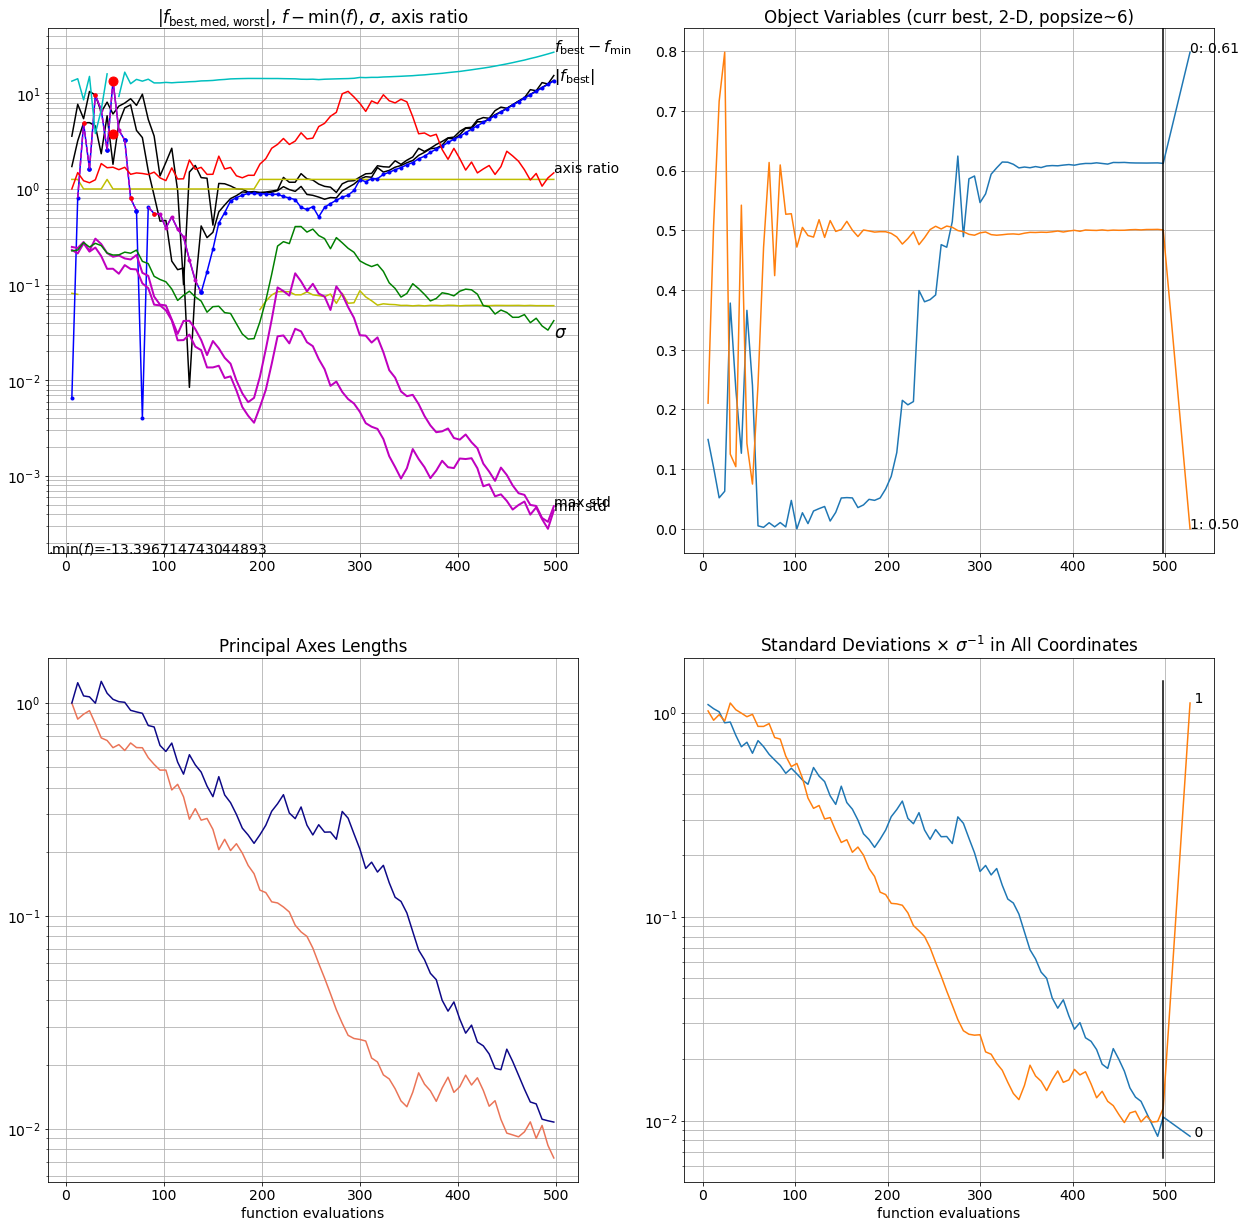

In [49]:
plt.rc('font', size=14) 

es.plot()

fig = plt.gcf()
fig.set_figwidth(18)
fig.set_figheight(18)

In [50]:
cfun.best_feas.info

{'x': array([0.05266098, 0.50048263]),
 'f': 0.8937883560994414,
 'g': [-0.20943952189569023],
 'f_al': 0.8937883560994414,
 'g_al': [0.0],
 'count': 193}

In [51]:
x = cfun.best_feas.info['x']
print("Solution:", scale_x(x, env_bounds))
print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

Solution: [ 0.1062693  10.01015219]
Worst-case robustness value: -0.20943952189569023


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [ ]:
# c = es.countiter
# x = cfun.find_feasible(es)
# print("find_feasible took {} iterations".format(es.countiter - c))
# print("Solution:", scale_x(x, env_bounds))
# print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

### CMA for finding the maximum deviation s.t. the agent is safe

In [52]:
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

cfun = cma.ConstrainedFitnessAL(
    lambda x: -scaled_deviation_dist(x), # maximize distance
    lambda x: [-scaled_cma_min_STL_robustness(x)], # robustness >= 0
#     find_feasible_first=True # assume the initial is already feasible
)
x, es = cma.fmin2(
    cfun,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolfun': 1e-3, 'tolx': 1e-5, 'timeout': 30 * 60},
    callback=cfun.update
)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=202456, Wed Jul  6 21:10:28 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -4.646584695945612e+00 1.0e+00 2.25e-01  2e-01  2e-01 0:27.6


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


    2     12 -8.610382024645252e+00 1.4e+00 2.20e-01  2e-01  3e-01 0:50.7
    3     18 -7.920845913566522e+00 1.8e+00 1.70e-01  2e-01  2e-01 1:06.6
    4     24 -1.185129519936201e+01 1.7e+00 1.62e-01  2e-01  2e-01 1:30.1
    5     30 -1.280688840507431e+01 1.6e+00 1.64e-01  1e-01  2e-01 1:53.3
    6     36 -1.388865823033783e+01 1.8e+00 1.71e-01  1e-01  2e-01 2:20.9
    7     42 -1.582767837727261e+01 1.8e+00 2.00e-01  2e-01  2e-01 2:49.3
    8     48 -1.684577281839343e+01 1.4e+00 2.33e-01  2e-01  2e-01 3:17.4
    9     54 -1.695501985870926e+01 1.2e+00 2.78e-01  2e-01  3e-01 3:45.0
   10     60 -1.677005549689691e+01 1.2e+00 2.53e-01  2e-01  2e-01 4:12.9
   11     66 -1.633867767086399e+01 1.4e+00 1.96e-01  1e-01  2e-01 4:40.9
   12     72 -1.651578691980925e+01 1.6e+00 1.54e-01  9e-02  1e-01 5:08.9
   13     78 -1.667951947740521e+01 1.5e+00 1.26e-01  7e-02  8e-02 5:37.3
   14     84 -1.640099636938085e+01 1.4e+00 9.51e-02  5e-02  5e-02 6:05.4
   15     90 -1.649468304534152e+01 1.

In [55]:
es.result

CMAEvolutionStrategyResult(xbest=array([0.71169487, 0.99985643]), fbest=-16.95501985870926, evals_best=50, evaluations=391, iterations=65, xfavorite=array([0.7293589 , 0.99987945]), stds=array([0.04524999, 0.00754246]), stop={'timeout': 1800})

In [60]:
# the original x-value may be meaningless
x = es.result.xbest
print("Solution:", scale_x(x, env_bounds))
print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

Solution: [ 1.42367804 19.99712871]
Worst-case robustness value: 0.08758469833250496


In [61]:
x = es.result.xfavorite
print("Solution:", scale_x(x, env_bounds))
print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

Solution: [ 1.45898843 19.99758912]
Worst-case robustness value: 0.07881518615599128


In [62]:
x = cfun.best_feas.info['x']
print("Solution:", scale_x(x, env_bounds))
print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

Solution: [ 1.59697713 19.9936731 ]
Worst-case robustness value: 0.07906540645475837


## Use SLSQP

In [ ]:
from scipy import optimize

res = optimize.minimize(
    min_deviation,
    x0,
    method='SLSQP',
    bounds=np.repeat([[0.0, 1.0]], len(x0), axis=0),
    constraints=[
        { 'type': 'ineq', 'fun': lambda x: -STL_robustness(x) } # STL_robustness(x) <= 0
    ]
)
print(res)